적대적 신경망(GAN)


In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

생성자(Generator)

In [2]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
# 128 : 임의의 노드 수(설정 값)
# 7*7 upsampling >> 14*14 >> 28*28
generator.add(BatchNormalization())
# 배치정규화 : input data 를 평균 0, 분산은 1이 되게 재배치
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D()) # 14*14 변환

generator.add(Conv2D(64, kernel_size=5, padding='same'))
# 5*5 filter(kernel) 사용 padding='same' : zero padding
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
# 14*14 >> 28*28로 변환

generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
# 'tanh' : -1 ~ 1 사이로 출력

판별자(discriminator)

In [3]:
# feature extraction (특징 추출 )

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
# strides = 2 >> pooling 과정 대체 효과
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

# -------------------------------------------------------------------
discriminator.add(Flatten()) # 2차원 >> 1차원
discriminator.add(Dense(1, activation='sigmoid'))


discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable=False
# 판별자 자신이 학습이 되지 않게 학습 기능을 꺼줘 (매우 중요 )


GAN NETWORK(생성자와 판별자 모델 연결)

In [4]:
ginput = Input(shape=(100,))
# 무작위로 100개 벡터값 집어 넣음

dis_output = discriminator(generator(ginput))
# 생성된 28*28 이미지 >> 판별자의 입력값을 들어감

gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
# 참, 거짓 분류
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________


In [5]:
# 신경망을 실행시키는(훈련) 함수 생성

def gan_train(epoch, batch_size, saving_interval):
    # MNIST 데이터 가죠옴(train data만)
    (x_train, _), (_, _) = mnist.load_data()
    # mnist 데이터 사용하되, x_train(이미지), y_train(라벨:이미지 이름)이라
    # 이미지만 사용하기 때문에 테스트 과정은 필요없어 x_train만 불러옴
    x_train = x_train.reshape(x_train.shape[0], 28,28,1).astype('float32')
    # 가로 세로 28*28,  흑백(1) 설정 >> 실수(float) 변환
    x_train = (x_train - 127.5) / 127.5
    # 픽셀 값 : 0~255 사이 값 >> tahn(y값 -1~1 값) >> 정규화

    # batch_size : 한 번에 몇 개의 실제 이미지(true)와 가상 이미지(fake)를 판별자에 넣을지 결정
    true = np.ones((batch_size, 1))
    # 모두 참(1)인 배결 생성 >> true (정답지)
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
    # 실제 데이터를 판별자에 입력
      idx = np.random.randint(0, x_train.shape[0], batch_size)
      # 실제 이미지를 무작위 선택, 불러옴
      # 0부터 x_train.shape[0](이미지 개수)까지 숫자 중 하나를 무작위 추출, batch_size 만큼 반복
      imgs = x_train[idx]
      # 선택된 숫자에 해당하는 이미지 불러오기
      d_loss_real = discriminator.train_on_batch(imgs, true)
      # 생성한 이미지와 모두 참(1)인 true배열(정답지)에 놓음
      # 여기에서 차이(오차) 발생하면 loss(손실)

      # 가상이미지를 판별자에 입력
      noise = np.random.normal(0,1, (batch_size, 100))
      # 가상 이미지를 무작위로 생성 >> noise
      # 정수가 아닌 실수 >> 정규분포 형태로 만들어줌
      # batch_size 만큼 100열 뽑음

      gan_imgs = generator.predict(noise)
      # noise(생성된 가상이미지) >> 생성자에 입력(예측)
      # 결과값이 gna_imgs 저장
      d_loss_fake = discriminator.train_on_batch(gan_imgs, fake)
      # 만들어진 가짜 이밎(gan_imgs)에 fake배열(모두 0)라벨이 붙음

      # 판별자(discriminator)와 생서장(generator) 오차 계산
      # d_loss_real, d_loss_fake 값을 더해서 1/2 로 나눈 평균 >> 판별자의 오차
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # 판별자의 오차
      g_loss = gan.train_on_batch(noise, true) #생성자의 오차

      print('epoch:%d'%i, 'd_loss:%.4f'%d_loss, 'g_loss:%.4f'%g_loss)

      if i % saving_interval == 0:
         # r, c = 5, 5
         noise = np.random.normal(0, 1, (25, 100))
         # 평균 0, 표준편차 1, 25개 샘플 차원 100
         gan_imgs = generator.predict(noise)

         # rescale imges 0-1
         gan_imgs = 0.5 * gan_imgs + 0.5

         fig, axs = plt.subplots(5, 5)
         count = 0
         for j in range(5):
          for k in range(5):
            axs[j, k].imshow(gan_imgs[count, :,:, 0], cmap='gray')
            axs[j, k].axis('off')
            count += 1
         plt.show()

    fig.savefig('./gan_mnist_%d.png'%i)

1/1 [==============================] - 0s 405ms/step
epoch:0 d_loss:0.6982 g_loss:0.3888
1/1 [==============================] - 0s 224ms/step


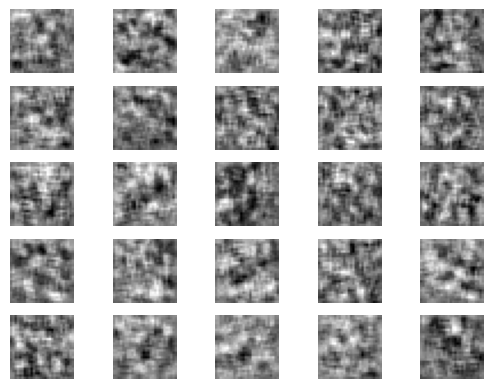

1/1 [==============================] - 0s 20ms/step
epoch:1 d_loss:0.4466 g_loss:0.0819
1/1 [==============================] - 0s 22ms/step
epoch:2 d_loss:0.5078 g_loss:0.0155
1/1 [==============================] - 0s 23ms/step
epoch:3 d_loss:0.6012 g_loss:0.0189
1/1 [==============================] - 0s 24ms/step
epoch:4 d_loss:0.5559 g_loss:0.0677
1/1 [==============================] - 0s 39ms/step
epoch:5 d_loss:0.4822 g_loss:0.2752
1/1 [==============================] - 0s 21ms/step
epoch:6 d_loss:0.4667 g_loss:0.5544
1/1 [==============================] - 0s 22ms/step
epoch:7 d_loss:0.4897 g_loss:0.6262
1/1 [==============================] - 0s 25ms/step
epoch:8 d_loss:0.4966 g_loss:0.6226
1/1 [==============================] - 0s 26ms/step
epoch:9 d_loss:0.4865 g_loss:0.5681
1/1 [==============================] - 0s 22ms/step
epoch:10 d_loss:0.4604 g_loss:0.5352
1/1 [==============================] - 0s 20ms/step
epoch:11 d_loss:0.4633 g_loss:0.4918
1/1 [=========================

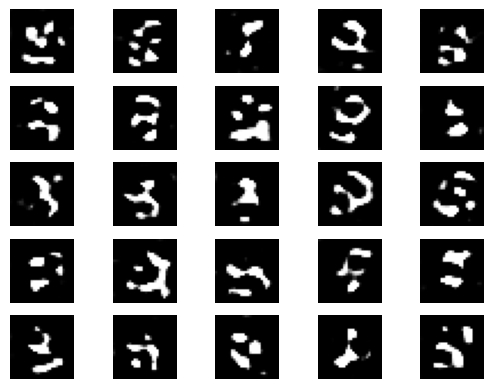

1/1 [==============================] - 0s 19ms/step
epoch:201 d_loss:0.8300 g_loss:1.9463
1/1 [==============================] - 0s 19ms/step
epoch:202 d_loss:1.0582 g_loss:1.7253
1/1 [==============================] - 0s 19ms/step
epoch:203 d_loss:0.7173 g_loss:1.5035
1/1 [==============================] - 0s 19ms/step
epoch:204 d_loss:0.8689 g_loss:1.6703
1/1 [==============================] - 0s 19ms/step
epoch:205 d_loss:0.6958 g_loss:1.9195
1/1 [==============================] - 0s 19ms/step
epoch:206 d_loss:0.6383 g_loss:2.4481
1/1 [==============================] - 0s 19ms/step
epoch:207 d_loss:0.5771 g_loss:2.3303
1/1 [==============================] - 0s 20ms/step
epoch:208 d_loss:0.5928 g_loss:2.5155
1/1 [==============================] - 0s 19ms/step
epoch:209 d_loss:0.6141 g_loss:2.7711
1/1 [==============================] - 0s 19ms/step
epoch:210 d_loss:0.5882 g_loss:2.5034
1/1 [==============================] - 0s 21ms/step
epoch:211 d_loss:0.5945 g_loss:2.1431
1/1 [=====

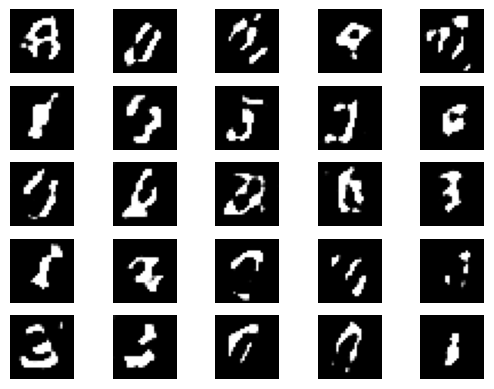

1/1 [==============================] - 0s 19ms/step
epoch:401 d_loss:0.4363 g_loss:2.1358
1/1 [==============================] - 0s 21ms/step
epoch:402 d_loss:0.3231 g_loss:1.9235
1/1 [==============================] - 0s 19ms/step
epoch:403 d_loss:0.3444 g_loss:2.2739
1/1 [==============================] - 0s 19ms/step
epoch:404 d_loss:0.4894 g_loss:1.8775
1/1 [==============================] - 0s 20ms/step
epoch:405 d_loss:0.4670 g_loss:1.8383
1/1 [==============================] - 0s 20ms/step
epoch:406 d_loss:0.4098 g_loss:1.7151
1/1 [==============================] - 0s 21ms/step
epoch:407 d_loss:0.3400 g_loss:1.8861
1/1 [==============================] - 0s 19ms/step
epoch:408 d_loss:0.2831 g_loss:2.0434
1/1 [==============================] - 0s 19ms/step
epoch:409 d_loss:0.4686 g_loss:1.8633
1/1 [==============================] - 0s 20ms/step
epoch:410 d_loss:0.4790 g_loss:1.8946
1/1 [==============================] - 0s 19ms/step
epoch:411 d_loss:0.3201 g_loss:2.3359
1/1 [=====

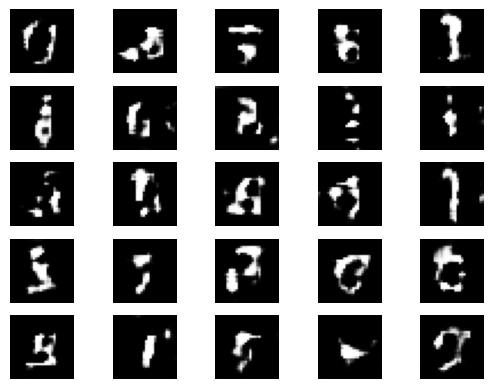

1/1 [==============================] - 0s 20ms/step
epoch:601 d_loss:0.7943 g_loss:1.3204
1/1 [==============================] - 0s 18ms/step
epoch:602 d_loss:0.4951 g_loss:1.5263
1/1 [==============================] - 0s 18ms/step
epoch:603 d_loss:0.3380 g_loss:1.7265
1/1 [==============================] - 0s 19ms/step
epoch:604 d_loss:0.2766 g_loss:2.5280
1/1 [==============================] - 0s 18ms/step
epoch:605 d_loss:0.6125 g_loss:1.1382
1/1 [==============================] - 0s 18ms/step
epoch:606 d_loss:0.5318 g_loss:0.9728
1/1 [==============================] - 0s 18ms/step
epoch:607 d_loss:0.3310 g_loss:1.7507
1/1 [==============================] - 0s 19ms/step
epoch:608 d_loss:0.4040 g_loss:1.3549
1/1 [==============================] - 0s 19ms/step
epoch:609 d_loss:0.3044 g_loss:2.0204
1/1 [==============================] - 0s 19ms/step
epoch:610 d_loss:0.3000 g_loss:2.3546
1/1 [==============================] - 0s 19ms/step
epoch:611 d_loss:0.2857 g_loss:2.0723
1/1 [=====

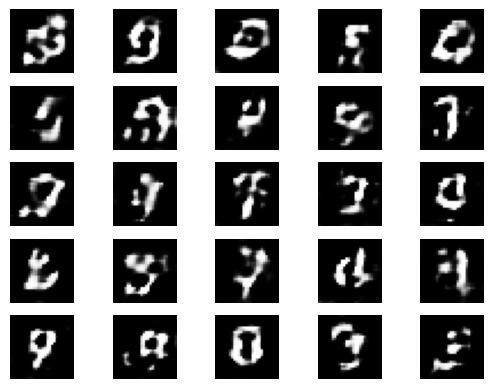

1/1 [==============================] - 0s 20ms/step
epoch:801 d_loss:0.7616 g_loss:0.8009
1/1 [==============================] - 0s 19ms/step
epoch:802 d_loss:0.6726 g_loss:0.9772
1/1 [==============================] - 0s 18ms/step
epoch:803 d_loss:0.6758 g_loss:0.7436
1/1 [==============================] - 0s 19ms/step
epoch:804 d_loss:0.7671 g_loss:1.0023
1/1 [==============================] - 0s 19ms/step
epoch:805 d_loss:0.6551 g_loss:0.9255
1/1 [==============================] - 0s 21ms/step
epoch:806 d_loss:0.6070 g_loss:0.9133
1/1 [==============================] - 0s 19ms/step
epoch:807 d_loss:0.6180 g_loss:0.9939
1/1 [==============================] - 0s 19ms/step
epoch:808 d_loss:0.6284 g_loss:1.0062
1/1 [==============================] - 0s 18ms/step
epoch:809 d_loss:0.5202 g_loss:1.1738
1/1 [==============================] - 0s 20ms/step
epoch:810 d_loss:0.5072 g_loss:1.2088
1/1 [==============================] - 0s 21ms/step
epoch:811 d_loss:0.3906 g_loss:1.3623
1/1 [=====

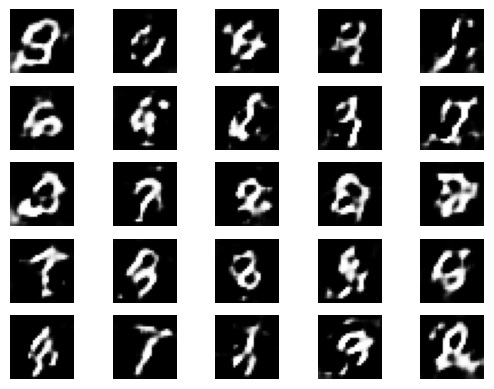

1/1 [==============================] - 0s 19ms/step
epoch:1001 d_loss:0.3276 g_loss:2.0481
1/1 [==============================] - 0s 20ms/step
epoch:1002 d_loss:0.3088 g_loss:2.2298
1/1 [==============================] - 0s 19ms/step
epoch:1003 d_loss:0.3353 g_loss:2.3566
1/1 [==============================] - 0s 19ms/step
epoch:1004 d_loss:0.3948 g_loss:2.0926
1/1 [==============================] - 0s 18ms/step
epoch:1005 d_loss:0.3019 g_loss:2.3607
1/1 [==============================] - 0s 18ms/step
epoch:1006 d_loss:0.4337 g_loss:2.0445
1/1 [==============================] - 0s 18ms/step
epoch:1007 d_loss:0.4646 g_loss:1.7095
1/1 [==============================] - 0s 19ms/step
epoch:1008 d_loss:0.4097 g_loss:1.6974
1/1 [==============================] - 0s 19ms/step
epoch:1009 d_loss:0.3760 g_loss:1.9746
1/1 [==============================] - 0s 19ms/step
epoch:1010 d_loss:0.4396 g_loss:2.1467
1/1 [==============================] - 0s 18ms/step
epoch:1011 d_loss:0.3856 g_loss:2.1714

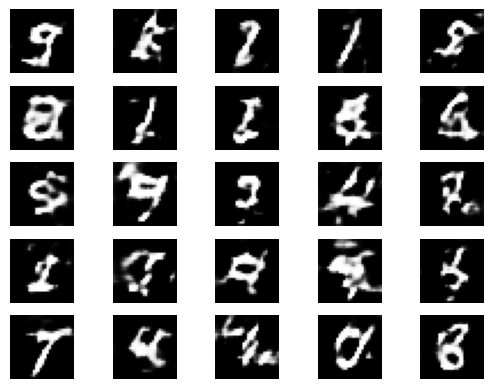

1/1 [==============================] - 0s 21ms/step
epoch:1201 d_loss:0.5458 g_loss:1.7732
1/1 [==============================] - 0s 20ms/step
epoch:1202 d_loss:0.3741 g_loss:2.0268
1/1 [==============================] - 0s 20ms/step
epoch:1203 d_loss:0.4329 g_loss:2.0242
1/1 [==============================] - 0s 21ms/step
epoch:1204 d_loss:0.4445 g_loss:1.9906
1/1 [==============================] - 0s 22ms/step
epoch:1205 d_loss:0.6753 g_loss:1.5978
1/1 [==============================] - 0s 19ms/step
epoch:1206 d_loss:0.5207 g_loss:2.0277
1/1 [==============================] - 0s 20ms/step
epoch:1207 d_loss:0.4649 g_loss:2.1610
1/1 [==============================] - 0s 20ms/step
epoch:1208 d_loss:0.4932 g_loss:1.7495
1/1 [==============================] - 0s 21ms/step
epoch:1209 d_loss:0.6304 g_loss:1.7209
1/1 [==============================] - 0s 19ms/step
epoch:1210 d_loss:0.5130 g_loss:1.6111
1/1 [==============================] - 0s 20ms/step
epoch:1211 d_loss:0.5867 g_loss:1.1868

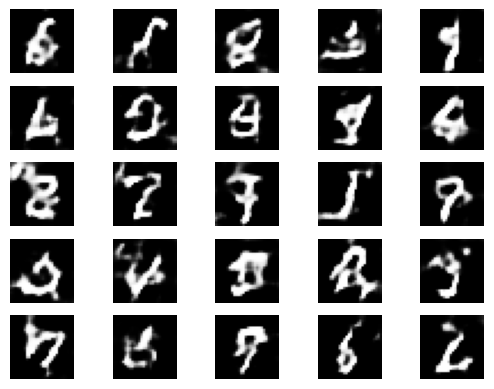

1/1 [==============================] - 0s 20ms/step
epoch:1401 d_loss:0.3647 g_loss:2.3444
1/1 [==============================] - 0s 22ms/step
epoch:1402 d_loss:0.3379 g_loss:2.4968
1/1 [==============================] - 0s 19ms/step
epoch:1403 d_loss:0.3621 g_loss:1.8790
1/1 [==============================] - 0s 19ms/step
epoch:1404 d_loss:0.3860 g_loss:2.1238
1/1 [==============================] - 0s 21ms/step
epoch:1405 d_loss:0.3831 g_loss:1.9339
1/1 [==============================] - 0s 19ms/step
epoch:1406 d_loss:0.4190 g_loss:2.1272
1/1 [==============================] - 0s 21ms/step
epoch:1407 d_loss:0.5078 g_loss:2.5423
1/1 [==============================] - 0s 20ms/step
epoch:1408 d_loss:0.4801 g_loss:3.3168
1/1 [==============================] - 0s 21ms/step
epoch:1409 d_loss:0.5528 g_loss:2.1484
1/1 [==============================] - 0s 19ms/step
epoch:1410 d_loss:0.6851 g_loss:1.4829
1/1 [==============================] - 0s 19ms/step
epoch:1411 d_loss:0.9326 g_loss:1.1800

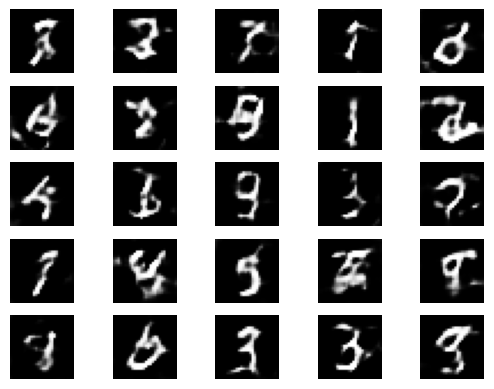

1/1 [==============================] - 0s 22ms/step
epoch:1601 d_loss:0.4984 g_loss:1.5637
1/1 [==============================] - 0s 21ms/step
epoch:1602 d_loss:0.3041 g_loss:1.7456
1/1 [==============================] - 0s 22ms/step
epoch:1603 d_loss:0.4362 g_loss:2.0923
1/1 [==============================] - 0s 21ms/step
epoch:1604 d_loss:0.3556 g_loss:1.9993
1/1 [==============================] - 0s 23ms/step
epoch:1605 d_loss:0.4478 g_loss:2.2624
1/1 [==============================] - 0s 22ms/step
epoch:1606 d_loss:0.3928 g_loss:2.2436
1/1 [==============================] - 0s 21ms/step
epoch:1607 d_loss:0.4662 g_loss:1.8365
1/1 [==============================] - 0s 23ms/step
epoch:1608 d_loss:0.4323 g_loss:1.8196
1/1 [==============================] - 0s 20ms/step
epoch:1609 d_loss:0.3880 g_loss:1.9502
1/1 [==============================] - 0s 20ms/step
epoch:1610 d_loss:0.3563 g_loss:2.0097
1/1 [==============================] - 0s 21ms/step
epoch:1611 d_loss:0.5525 g_loss:1.6640

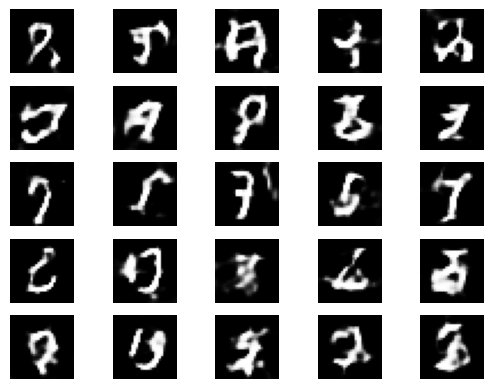

1/1 [==============================] - 0s 19ms/step
epoch:1801 d_loss:0.5757 g_loss:1.2992
1/1 [==============================] - 0s 19ms/step
epoch:1802 d_loss:0.4098 g_loss:1.7062
1/1 [==============================] - 0s 19ms/step
epoch:1803 d_loss:0.5244 g_loss:1.8429
1/1 [==============================] - 0s 18ms/step
epoch:1804 d_loss:0.4359 g_loss:1.9560
1/1 [==============================] - 0s 19ms/step
epoch:1805 d_loss:0.4907 g_loss:1.3975
1/1 [==============================] - 0s 18ms/step
epoch:1806 d_loss:0.5554 g_loss:1.4500
1/1 [==============================] - 0s 19ms/step
epoch:1807 d_loss:0.5644 g_loss:1.4573
1/1 [==============================] - 0s 19ms/step
epoch:1808 d_loss:0.4497 g_loss:1.7167
1/1 [==============================] - 0s 19ms/step
epoch:1809 d_loss:0.5939 g_loss:1.7495
1/1 [==============================] - 0s 19ms/step
epoch:1810 d_loss:0.4043 g_loss:1.8294
1/1 [==============================] - 0s 18ms/step
epoch:1811 d_loss:0.4957 g_loss:1.6970

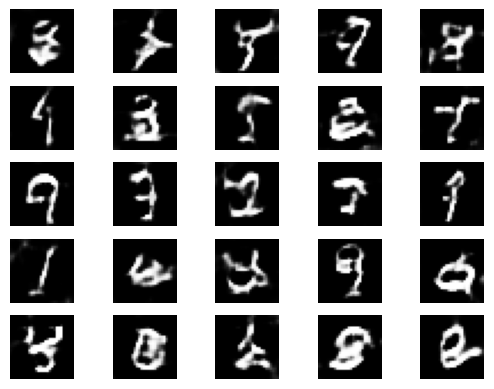

In [7]:
gan_train(2001, 32, 200)
# 2000번 반복, batch_size=32, 200번 마다 결과 저장

In [9]:
# 여기서 잠깐

import numpy as np

# np.ones((10, 1))
# np.zeros((5,1))
# np.random.normal(0,1, (5, 100))